In [1]:
%load_ext autoreload
%autoreload 2

import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
import numpy as np
import utils
import preprocess
import dataset as dt
import pandas as pd
import csv
import torch
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
plt.rcParams['figure.figsize'] = [50,50]

In [2]:
def split_df(df, n):
    '''
    df: dataframe to shuffle and split
    n: amount of to be splitted pieces
    splits: list of dataframes (splits)
    '''
    # defining list with optimal cutting points
    split_points = list(map(lambda x: int(x * len(df) / n), (list(range(1, n)))))
    # shuffling the df, then splitting it from split_points
    splits = list(np.split(df.sample(frac=1), split_points))
    return splits


def make_train_and_test(splits, index):
    '''
    Take splits from splitDf, and return into test set (splits[index])
    and training set (the rest)
    '''

    # index is zero based, so range 0-9 for 10 fold split
    test = splits[index]

    left_lst = splits[:index]
    right_lst = splits[index + 1:]

    train = pd.concat(left_lst + right_lst)
    return train, test

# create train,test annotation.csv

In [ ]:
raw_data_dir = 'data/raw/annotated/originals'

In [ ]:
annotations_df = pd.read_csv('./data/annotations.csv')

In [ ]:
annotations_df

In [ ]:
file_name = []
molar_yn = []
class_1 = []
class_2 = []
class_3 = []

for i,name in enumerate(annotations_df['File_name']):
    ## left side ##
    file_name.append(name+'_l')
    molar_yn.append(annotations_df['Left_molar_yn'][i])
    class_1.append(annotations_df['Class_1_Left'][i])
    class_2.append(annotations_df['Class_2_Left'][i])
    class_3.append(annotations_df['Class_3_Left_side'][i])
    
    ## right side ##
    file_name.append(name+'_r')
    molar_yn.append(annotations_df['Right_molar_yn'][i])
    class_1.append(annotations_df['Class_1_Right'][i])
    class_2.append(annotations_df['Class_2_Right'][i])
    class_3.append(annotations_df['Class_3_Right_side'][i])
    
new_annotations_df = pd.DataFrame({'File_name':file_name, 'molar_yn':molar_yn, 'class_1':class_1, 'class_2':class_2, 'class_3':class_3})


In [ ]:
with_molar_df = new_annotations_df[new_annotations_df['molar_yn']==1].reset_index(drop=True)
without_molar_df = new_annotations_df[new_annotations_df['molar_yn']==0].reset_index(drop=True)

In [ ]:
wm_splits = split_df(with_molar_df, 10)
wom_splits = split_df(without_molar_df, 10)

wm_train, wm_test = make_train_and_test(wm_splits, 1)
wom_train, wom_test = make_train_and_test(wom_splits, 1)

train_df = pd.concat([wm_train, wom_train]).sample(frac=1).reset_index(drop=True)
test_df = pd.concat([wm_test, wom_test]).sample(frac=1).reset_index(drop=True)

In [ ]:
#train_df.to_csv('data/annotated/train/train_annotations.csv', index=False)
#test_df.to_csv('data/annotated/test/test_annotations.csv', index=False)

# put images in corresponding folders

In [ ]:
train_df = pd.read_csv('data/annotated/train/train_annotations.csv')
test_df = pd.read_csv('data/annotated/test/test_annotations.csv')

In [ ]:
'''
train_patch_dir = 'data/annotated/train/patches/images_nmasks_original/'
test_patch_dir = 'data/annotated/test/patches/images_nmasks_original/'

for file in os.listdir(train_patch_dir):
    filename = os.fsdecode(file)
    if filename.endswith('.dcm'):
        if filename[:-4] not in list(train_df['File_name']):
            os.remove(train_patch_dir+filename)
            mask_name = filename[:-4] + '.gipl'
            os.remove(train_patch_dir+mask_name)
            
for file in os.listdir(test_patch_dir):
    filename = os.fsdecode(file)
    if filename.endswith('.dcm'):
        if filename[:-4] not in list(test_df['File_name']):
            os.remove(test_patch_dir+filename)
            mask_name = filename[:-4] + '.gipl'
            os.remove(test_patch_dir+mask_name'
'''

In [ ]:
## there is an incompatibility with numbers, investigate it

In [ ]:
images, masks, image_ids= utils.load_data('annotated/train/patches/images_nmasks_original')
images_te, masks_te, image_ids_te= utils.load_data('annotated/test/patches/images_nmasks_original')

### 0) update train and test csv

In [ ]:
train_df_new = train_df.copy()
test_df_new = test_df.copy()

for i,id in enumerate(list(train_df_new['File_name'])):
    if id not in image_ids:
        train_df_new.drop([i], inplace=True)
        
for i,id in enumerate(list(test_df_new['File_name'])):
    if id not in image_ids_te:
        test_df_new.drop([i], inplace=True)
    
train_df_new.reset_index(drop=True, inplace=True)
test_df_new.reset_index(drop=True, inplace=True)

In [ ]:
#train_df_new.to_csv('data/annotated/train/train_annotations.csv', index=False)
#test_df_new.to_csv('data/annotated/test/test_annotations.csv', index=False)

## 1) create UNet ready data

In [ ]:
images_nda = [sitk.GetArrayFromImage(image)[0, :, :] for image in images]
masks_nda = [sitk.GetArrayFromImage(mask)[0, :, :] for mask in masks]

images_te_nda = [sitk.GetArrayFromImage(image)[0, :, :] for image in images_te]
masks_te_nda = [sitk.GetArrayFromImage(mask)[0, :, :] for mask in masks_te]

In [ ]:
UNet_ready_masks_tr = []
UNet_ready_masks_te = []
no_mask = np.zeros((1100,1300), dtype='uint16')

for i,id in enumerate(image_ids):
    if int(train_df[train_df['File_name'] == id]['molar_yn']) == 0:
        UNet_ready_masks_tr.append(no_mask)
    else:
        UNet_ready_masks_tr.append(masks_nda[i])
        
for i,id in enumerate(image_ids_te):
    if int(test_df[test_df['File_name'] == id]['molar_yn']) == 0:
        UNet_ready_masks_te.append(no_mask)
    else:
        UNet_ready_masks_te.append(masks_te_nda[i])

In [ ]:
'''
UNet_train_dir = 'data/annotated/train/patches/train_ready_UNET/'
UNet_test_dir = 'data/annotated/test/patches/test_ready_UNET/'

for i,id in enumerate(image_ids):
    ## save image ##
    utils.save_image_new(images_nda[i], id, UNet_train_dir)
    ## save mask ##
    utils.save_image_new(UNet_ready_masks_tr[i], id, UNet_train_dir, extension = '.gipl')
    
for i,id in enumerate(image_ids_te):
    ## save image ##
    utils.save_image_new(images_te_nda[i], id, UNet_test_dir)
    ## save mask ##
    utils.save_image_new(UNet_ready_masks_te[i], id, UNet_test_dir, extension = '.gipl')
'''

## 2) create yolo ready data

In [ ]:
# create string to save in label.txt for yolo

# train
strings_tr = []
for i,image_id in enumerate(image_ids):
    if int(train_df[train_df['File_name'] == image_id]['molar_yn']) == 1:
        string = preprocess.prepare_yolo_labels_from_masks(masks_nda[i], box_dimensions=300)
    else:
        string = ''
    strings_tr.append(string)
    
# test
strings_te = []
for i,image_id in enumerate(image_ids_te):
    if int(test_df[test_df['File_name'] == image_id]['molar_yn']) == 1:
        string = preprocess.prepare_yolo_labels_from_masks(masks_te_nda[i], box_dimensions=300)
    else:
        string = ''
    strings_te.append(string)

In [ ]:
# create train, valid split

ratio = 0.8
ratio_index = int(len(strings_tr) * ratio)

train_images_patches = images_nda[:ratio_index]
valid_images_patches = images_nda[ratio_index:]

train_strings = strings_tr[:ratio_index]
valid_strings = strings_tr[ratio_index:]

train_new_image_ids = image_ids[:ratio_index]
valid_new_image_ids = image_ids[ratio_index:]

In [ ]:
# save yolo labels
'''
train_image_path = 'data/annotated/yolo_data/train/images/'
valid_image_path = 'data/annotated/yolo_data/valid/images/'
test_image_path = 'data/annotated/yolo_data/test/images/'

train_label_path = 'data/annotated/yolo_data/train/labels/'
valid_label_path = 'data/annotated/yolo_data/valid/labels/'
test_label_path = 'data/annotated/yolo_data/test/labels/'

# train data
for i, name in enumerate(train_new_image_ids):
    # write image
    utils.save_image_new(train_images_patches[i], name, path = train_image_path)
    # write mask string
    with open(train_label_path+name+'.txt', 'w') as filehandle:
        filehandle.write(train_strings[i])

# valid dat
for i, name in enumerate(valid_new_image_ids):
    # write image
    utils.save_image_new(valid_images_patches[i], name, path = valid_image_path)
    # write mask string
    with open(valid_label_path+name+'.txt', 'w') as filehandle:
        filehandle.write(valid_strings[i])
        
# test data
for i, name in enumerate(image_ids_te):
    # write image
    utils.save_image_new(images_te_nda[i], name, path = test_image_path)
    # write mask string
    with open(test_label_path+name+'.txt', 'w') as filehandle:
        filehandle.write(strings_te[i])
'''

# 3) create data with molar only

In [ ]:
regression_train_dir = 'data/annotated/train/patches/train_ready_Regression/'
regression_test_dir = 'data/annotated/test/patches/test_ready_Regression/'

for i,id in enumerate(image_ids):
    if int(train_df[train_df['File_name'] == id]['molar_yn']) == 1:
        ## save image ##
        utils.save_image_new(images_nda[i], id, regression_train_dir)
        ## save mask ##
        utils.save_image_new(UNet_ready_masks_tr[i], id, regression_train_dir, extension = '.gipl')
    
for i,id in enumerate(image_ids_te):
    if int(test_df[test_df['File_name'] == id]['molar_yn']) == 1:
        ## save image ##
        utils.save_image_new(images_te_nda[i], id, regression_test_dir)
        ## save mask ##
        utils.save_image_new(UNet_ready_masks_te[i], id, regression_test_dir, extension = '.gipl')

In [ ]:
## create train/test.csv with molars ##

train_df_w_molar = train_df[train_df['molar_yn'] == 1].reset_index(drop=True)
test_df_w_molar = test_df[test_df['molar_yn'] == 1].reset_index(drop=True)

#train_df_w_molar.to_csv('data/annotated/train/train_annotations_w_molar.csv', index=False)
#test_df_w_molar.to_csv('data/annotated/test/test_annotations_w_molar.csv', index=False)

# ----------------------------------

# create new annotations for cv

# ----------------------------------

In [ ]:
raw_data_dir = 'data/raw/annotated/originals'
annotations_df = pd.read_csv('./data/annotations.csv')

In [ ]:
file_name = []
molar_yn = []
class_1 = []
class_2 = []
class_3 = []

for i,name in enumerate(annotations_df['File_name']):
    ## left side ##
    file_name.append(name+'_l')
    molar_yn.append(annotations_df['Left_molar_yn'][i])
    class_1.append(annotations_df['Class_1_Left'][i])
    class_2.append(annotations_df['Class_2_Left'][i])
    class_3.append(annotations_df['Class_3_Left_side'][i])
    
    ## right side ##
    file_name.append(name+'_r')
    molar_yn.append(annotations_df['Right_molar_yn'][i])
    class_1.append(annotations_df['Class_1_Right'][i])
    class_2.append(annotations_df['Class_2_Right'][i])
    class_3.append(annotations_df['Class_3_Right_side'][i])
    
new_annotations_df = pd.DataFrame({'File_name':file_name, 'molar_yn':molar_yn, 'class_1':class_1, 'class_2':class_2, 'class_3':class_3})

In [ ]:
with_molar_df = new_annotations_df[new_annotations_df['molar_yn']==1].reset_index(drop=True)
without_molar_df = new_annotations_df[new_annotations_df['molar_yn']==0].reset_index(drop=True)

In [ ]:
images, masks, image_ids= utils.load_data('annotated/patches/images_nmasks')

wm_splits = split_df(with_molar_df, 5)
wom_splits = split_df(without_molar_df, 5)

for i in range(5):
    
    wm_train, wm_test = make_train_and_test(wm_splits, i)
    wom_train, wom_test = make_train_and_test(wom_splits, i)

    wm_train.reset_index(drop=True, inplace=True)
    wm_test.reset_index(drop=True, inplace=True)
    for j,id in enumerate(list(wm_train['File_name'])):
        if id not in image_ids:
            wm_train.drop([j], inplace=True)
        
    for k,id in enumerate(list(wm_test['File_name'])):
        if id not in image_ids:
            wm_test.drop([k], inplace=True)
    wm_train.reset_index(drop=True, inplace=True)
    wm_test.reset_index(drop=True, inplace=True)
    
    wom_train.reset_index(drop=True, inplace=True)
    wom_test.reset_index(drop=True, inplace=True)
    for j,id in enumerate(list(wom_train['File_name'])):
        if id not in image_ids:
            wom_train.drop([j], inplace=True)
        
    for k,id in enumerate(list(wom_test['File_name'])):
        if id not in image_ids:
            wom_test.drop([k], inplace=True)
    wom_train.reset_index(drop=True, inplace=True)
    wom_test.reset_index(drop=True, inplace=True)
    
    train_df = pd.concat([wm_train, wom_train]).sample(frac=1).reset_index(drop=True)
    test_df = pd.concat([wm_test, wom_test]).sample(frac=1).reset_index(drop=True)
    
    save_path_all = 'data/annotated/annotations/all/cv'+str(i+1)+'/'
    save_path_w_molar = 'data/annotated/annotations/with_molar/cv'+str(i+1)+'/'
    
    ############################################
    train_df.to_csv(save_path_all+'train_annotations.csv', index=False)
    test_df.to_csv(save_path_all+'test_annotations.csv', index=False)
    
    wm_train.to_csv(save_path_w_molar+'train_annotations.csv', index=False)
    wm_test.to_csv(save_path_w_molar+'test_annotations.csv', index=False)
    ############################################
    
    
    ## yolo train valid split ##
    
    yolo_wm_splits = split_df(wm_train, 5)
    yolo_wom_splits = split_df(wom_train, 5)
    
    y_wm_train, y_wm_valid = make_train_and_test(yolo_wm_splits, 0)
    y_wom_train, y_wom_valid = make_train_and_test(yolo_wom_splits, 0)

    y_train_df = pd.concat([y_wm_train, y_wom_train]).sample(frac=1).reset_index(drop=True)
    y_valid_df = pd.concat([y_wm_valid, y_wom_valid]).sample(frac=1).reset_index(drop=True)
    
    save_path_yolo = 'data/annotated/annotations/yolo_annotations/cv'+str(i+1)+'/'
    
    ###
    y_train_df.to_csv(save_path_yolo+'train_annotations.csv', index=False)
    y_valid_df.to_csv(save_path_yolo+'valid_annotations.csv', index=False)
    test_df.to_csv(save_path_yolo+'test_annotations.csv', index=False)
    ###
        
    

# New data

In [ ]:
# TODO: get rid of non-similar parts of the name (for image and mask)

In [ ]:
new_data_csv = pd.read_csv('./data_new/AI4DentalImaging_Annotation - Sheet1.csv', header=1)

In [ ]:
new_data_csv.dropna(axis=0, how='all', inplace=True)
new_data_csv.dropna(how='any',subset=['Left_molar_yn', 'Right_molar_yn'], inplace=True)
new_data_csv.drop_duplicates(subset='File_name', inplace=True)
new_data_csv['Left_molar_yn'] = new_data_csv['Left_molar_yn'].apply(lambda x: int(x))
new_data_csv['Right_molar_yn'] = new_data_csv['Right_molar_yn'].apply(lambda x: int(x))
new_data_csv.reset_index(drop=True, inplace=True)

In [ ]:
print(len(new_data_csv))
print(len(annotations_df))

In [ ]:
#new_data_csv.to_csv('./data/annotations_new.csv', index=False)
new_data_csv = pd.read_csv('./data/annotations_new.csv')

In [ ]:
new_names = [x for x in new_data_csv['File_name'] if x not in list(annotations_df['File_name'])]

In [ ]:
len(new_names)

In [ ]:
new_data_csv.tail(10)

In [ ]:
new_raw_data_dir = 'data_new/raw/annotated/originals/'
new_images = [f for f in os.listdir(new_raw_data_dir) ]

image_names = []
mask_names = []
image_dict = {}

for im in new_images:
    if im[-3:] == 'dcm':
        study_id = im.split()[-1][:-4]
        found = 0
        for ma in new_images:
            if ma[-4:] == 'gipl':
                if ma.split()[-1][:-5] == study_id:
                    found = 1
                    corresponding_mask = ma
        if found == 1:
            image_names.append(im)
            mask_names.append(corresponding_mask)
            image_dict[im] = corresponding_mask

In [ ]:
query_data_dir = './data_new/raw/annotated/originals/'
image_nmasks_dir = './data/annotated/patches/images_nmasks/'
image_nmasks_original_dir = './data/annotated/patches/images_nmasks_original/'
labels_dir = './data/annotated/patches/labels/' # for YOLO

In [ ]:
from preprocess import extract_patches, build_new_mask, prepare_yolo_labels_from_masks
from utils import save_image_new

In [ ]:
counter = 0
for name in image_names:
    patient_id = name.split()[-1][:-4]
    mask_name = image_dict[name]
    
    image = sitk.ReadImage(query_data_dir+name)
    mask = sitk.ReadImage(query_data_dir+mask_name)

    image = sitk.GetArrayFromImage(image)
    mask = sitk.GetArrayFromImage(mask)
    
    right_image, left_image = extract_patches(image)
    # IMPORTANT NOTE: patients left and right, not images! The function is written as images left and right
    rigt_mask_or, left_mask_or = extract_patches(mask)
    
    if name[:-4] not in list(new_data_csv['File_name']):
        continue
    
    if int(new_data_csv[new_data_csv['File_name'] == name[:-4]]['Left_molar_yn']) == 0:
        left_mask_or = np.zeros((1100,1300), dtype=np.uint16)
        left_mask = np.zeros((1100,1300), dtype=np.uint16)
        left_label = ''
    else:
        left_label = prepare_yolo_labels_from_masks(left_mask_or, box_dimensions=300)
        left_mask = build_new_mask(left_mask_or)
        
    if int(new_data_csv[new_data_csv['File_name'] == name[:-4]]['Right_molar_yn']) == 0:
        rigt_mask_or = np.zeros((1100,1300), dtype=np.uint16)
        rigt_mask = np.zeros((1100,1300), dtype=np.uint16)
        right_label = ''
    else:
        right_label = prepare_yolo_labels_from_masks(rigt_mask_or, box_dimensions=300)
        rigt_mask = build_new_mask(rigt_mask_or)
        
    
    # PUT THEM IN image_nmasks_dir !!!!!
    save_image_new(right_image, patient_id+'_r', image_nmasks_original_dir, extension = '.dcm')
    save_image_new(left_image, patient_id+'_l', image_nmasks_original_dir, extension = '.dcm')
    save_image_new(rigt_mask_or, patient_id+'_r', image_nmasks_original_dir, extension = '.gipl')
    save_image_new(left_mask_or, patient_id+'_l', image_nmasks_original_dir, extension = '.gipl')
    with open(labels_dir+patient_id+'_r'+'.txt', 'w') as filehandle:
        filehandle.write(right_label)
    with open(labels_dir+patient_id+'_l'+'.txt', 'w') as filehandle:
        filehandle.write(left_label)
        
    counter += 1
    if counter % 50 == 0:
        print(counter, ' done')

        
new_data_csv2 = new_data_csv.copy()
new_data_csv2['File_name'] = new_data_csv2['File_name'].apply(lambda x: x.split()[-1])
new_data_csv2.to_csv('./data/annotations_new2.csv', index=False)
        


In [ ]:
new_data_csv2.head()

In [ ]:
# check if all annotations.csv names are existent
documents = [f for f in os.listdir(image_nmasks_original_dir)]
counter = 0
missing = []
for name in list(new_data_csv2['File_name']):
    r_im_name = name+'_r'+'.dcm'
    l_im_name = name+'_l'+'.dcm'
    if r_im_name not in documents:
        counter += 1
        missing.append(r_im_name)
    if l_im_name not in documents:
        counter += 1
        missing.append(l_im_name)
        
print(counter)

In [ ]:
missing

In [ ]:
file_name = []
molar_yn = []
class_1 = []
class_2 = []
class_3 = []

for i,name in enumerate(new_data_csv2['File_name']):
    ## left side ##
    file_name.append(name+'_l')
    molar_yn.append(new_data_csv2['Left_molar_yn'][i])
    class_1.append(new_data_csv2['Class_1_Left'][i])
    class_2.append(new_data_csv2['Class_2_Left'][i])
    class_3.append(new_data_csv2['Class_3_Left_side'][i])
    
    ## right side ##
    file_name.append(name+'_r')
    molar_yn.append(new_data_csv2['Right_molar_yn'][i])
    class_1.append(new_data_csv2['Class_1_Right'][i])
    class_2.append(new_data_csv2['Class_2_Right'][i])
    class_3.append(new_data_csv2['Class_3_Right_side'][i])
    
new_annotations2_df = pd.DataFrame({'File_name':file_name, 'molar_yn':molar_yn, 'class_1':class_1, 'class_2':class_2, 'class_3':class_3})

In [ ]:
with_molar_df2 = new_annotations2_df[new_annotations2_df['molar_yn']==1].reset_index(drop=True)
without_molar_df2 = new_annotations2_df[new_annotations2_df['molar_yn']==0].reset_index(drop=True)

In [ ]:
images, masks, image_ids = utils.load_data('annotated/patches/images_nmasks_original')

wm_splits = split_df(with_molar_df2, 5)
wom_splits = split_df(without_molar_df2, 5)

for i in range(5):
    
    wm_train, wm_test = make_train_and_test(wm_splits, i)
    wom_train, wom_test = make_train_and_test(wom_splits, i)

    wm_train.reset_index(drop=True, inplace=True)
    wm_test.reset_index(drop=True, inplace=True)
    for j,id in enumerate(list(wm_train['File_name'])):
        if id not in image_ids:
            wm_train.drop([j], inplace=True)
        
    for k,id in enumerate(list(wm_test['File_name'])):
        if id not in image_ids:
            wm_test.drop([k], inplace=True)
    wm_train.reset_index(drop=True, inplace=True)
    wm_test.reset_index(drop=True, inplace=True)
    
    wom_train.reset_index(drop=True, inplace=True)
    wom_test.reset_index(drop=True, inplace=True)
    for j,id in enumerate(list(wom_train['File_name'])):
        if id not in image_ids:
            wom_train.drop([j], inplace=True)
        
    for k,id in enumerate(list(wom_test['File_name'])):
        if id not in image_ids:
            wom_test.drop([k], inplace=True)
    wom_train.reset_index(drop=True, inplace=True)
    wom_test.reset_index(drop=True, inplace=True)
    
    train_df = pd.concat([wm_train, wom_train]).sample(frac=1).reset_index(drop=True)
    test_df = pd.concat([wm_test, wom_test]).sample(frac=1).reset_index(drop=True)
    
    save_path_all = 'data/annotated/annotations/all/cv'+str(i+1)+'/'
    save_path_w_molar = 'data/annotated/annotations/with_molar/cv'+str(i+1)+'/'
    
    ############################################
    train_df.to_csv(save_path_all+'train_annotations.csv', index=False)
    test_df.to_csv(save_path_all+'test_annotations.csv', index=False)
    
    wm_train.to_csv(save_path_w_molar+'train_annotations.csv', index=False)
    wm_test.to_csv(save_path_w_molar+'test_annotations.csv', index=False)
    ############################################
    
    
    ## yolo train valid split ##
    
    yolo_wm_splits = split_df(wm_train, 5)
    yolo_wom_splits = split_df(wom_train, 5)
    
    y_wm_train, y_wm_valid = make_train_and_test(yolo_wm_splits, 0)
    y_wom_train, y_wom_valid = make_train_and_test(yolo_wom_splits, 0)

    y_train_df = pd.concat([y_wm_train, y_wom_train]).sample(frac=1).reset_index(drop=True)
    y_valid_df = pd.concat([y_wm_valid, y_wom_valid]).sample(frac=1).reset_index(drop=True)
    
    save_path_yolo = 'data/annotated/annotations/yolo_annotations/cv'+str(i+1)+'/'
    
    ###
    y_train_df.to_csv(save_path_yolo+'train_annotations.csv', index=False)
    y_valid_df.to_csv(save_path_yolo+'valid_annotations.csv', index=False)
    test_df.to_csv(save_path_yolo+'test_annotations.csv', index=False)
    ###
        
    

In [ ]:
test = pd.read_csv('./data/annotated/annotations/all/cv1/train_annotations.csv')

In [ ]:
test.head(10)

In [ ]:
index = 2

name = test['File_name'][index]

In [ ]:
image = sitk.ReadImage(image_nmasks_original_dir+name+'.dcm')
mask = sitk.ReadImage(image_nmasks_original_dir+name+'.gipl')

image = sitk.GetArrayFromImage(image)
mask = sitk.GetArrayFromImage(mask)

In [ ]:
plt.imshow(image[0,:,:])

In [ ]:
plt.imshow(image[0,:,:] ** mask[0,:,:])

# Examine

In [ ]:
image = sitk.ReadImage('data/annotated/patches/images_nmasks_original/20_02.dcm-55_r.dcm')
mask = sitk.ReadImage('data/annotated/patches/images_nmasks_original/20_02.dcm-55_r.gipl')

In [ ]:
image = sitk.GetArrayFromImage(image)
mask = sitk.GetArrayFromImage(mask)

In [ ]:
image=image.reshape(1100,1300)
mask=mask.reshape(1100,1300)

In [ ]:
plt.imshow(image)

In [ ]:
plt.imshow(mask)

In [ ]:
from scipy.ndimage.measurements import center_of_mass

In [ ]:
def extract_ROI(image, mask, window_size = 150):

    # Get mask centroid
    c1, c2 = center_of_mass(mask)
    c1, c2 = int(c1), int(c2)
    # Reshape image according to window_size
    image = image[c1 - window_size:c1 + window_size, c2 - window_size:c2 + window_size]

    return image

In [ ]:
ROI = extract_ROI(image,mask, window_size = 256)

In [ ]:
plt.imshow(ROI)

In [ ]:
ROI = ROI.astype(np.int64)

In [ ]:
ROI = torch.Tensor(ROI)

In [ ]:
ROI = ROI.unsqueeze(0)

In [ ]:
ROI.std()

In [ ]:
ROI.shape

In [ ]:
'vblabsv.dcm'[:-4]

In [ ]:
ooo = pd.read_csv('data/annotated/annotations/all/cv1/train_annotations.csv')
ooo = ooo[ooo['molar_yn'] == 1].iloc[:, [0, 2, 3, 4]]

In [ ]:
ooo.iloc[0,2]

In [ ]:
ooo

In [ ]:
labels = int(ooo.iloc[0, 1]-1)
labels = torch.Tensor(ooo.iloc[0, 1]-1)

In [ ]:
ooo.iloc[0, 1]-1

In [ ]:
class DentalImagingDataset(Dataset):

    def __init__(self, root_dir,
                  csv_file, transform=None, considered_class = 1, ROI_size = 256): # considered_class 1,2 or 3 (see annotations.csv)

        self.annotations = pd.read_csv(csv_file)
        self.annotations = self.annotations[self.annotations['molar_yn'] == 1].iloc[:, [0, 2, 3, 4]]

        self.rootdir = root_dir
        self.transform = transform
        self.considered_class = considered_class
        self.ROI_size = ROI_size

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, item):

        # Image
        file_name = self.annotations.iloc[item, 0] + '.dcm'
        mask_name = file_name[:-4] + '.gipl'
        file_path = os.path.join(self.rootdir, file_name)
        mask_path = os.path.join(self.rootdir, mask_name)
        image = sitk.GetArrayFromImage(sitk.ReadImage(file_path))
        image = image.astype(float).reshape(image.shape[1], image.shape[2])
        mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
        mask = mask.astype(float).reshape(mask.shape[1], mask.shape[2])

        # Besic transforms: ROI extraction, to tensor, normalize
        image = extract_ROI(image, mask, self.ROI_size).astype(np.int64)
        image = torch.Tensor(image)
        image = image.unsqueeze(0)
        normalize = utils.Normalize()
        image = normalize(image)

        if self.transform is not None:
            image = self.transform(image)

        # Labels
        labels = int(self.annotations.iloc[item, self.considered_class]-1)

        sample = [image, labels]

        return sample

def returnOPGdata():

    ## remember to add RandomResizedCrop to the server (solve the problem by running)

    dset_dir = './data/annotated/patches/images_nmasks_original'
    csv_file = './data/annotated/annotations/all/cv1/train_annotations.csv'
    considered_class = 1
    ROI_size = 4

    batch_size = 1
    test_portion = 0.2
    num_workers = 1

    def split_sets(dset, test_portion):
        # Creating data indices for training and validation splits:
        dataset_size = len(dset)
        test_size = int(dataset_size * test_portion)
        train_size = int(dataset_size - test_size)

        valid_set, test_set = random_split(dset, [train_size, test_size])

        return valid_set, test_set

    dset = DentalImagingDataset(root_dir=dset_dir, csv_file=csv_file,
                                transform=None, considered_class=considered_class, ROI_size=ROI_size)

    train_set, test_set = split_sets(dset, test_portion)

    train_loader = DataLoader(train_set,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=num_workers,
                              pin_memory=True,
                              drop_last=False)

    test_loader = DataLoader(test_set,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=num_workers,
                             pin_memory=True,
                             drop_last=False)

    return train_loader, test_loader

In [ ]:
tr_loader, val_loader = returnOPGdata()

In [ ]:
for im, la in tr_loader:
    print('yes')

In [ ]:
torch.Tensor([0., 0., 1., 1.])

In [ ]:
x = torch.Tensor([np.nan,np.nan])

In [ ]:
bool(torch.isnan(x).any())

In [ ]:
x = torch.Tensor([[1,2],[3,4]])

In [ ]:
len(x.shape)

# =============================

In [ ]:
dir_images = './data/annotated/patches/images_nmasks/'
dir_labels = './data/annotated/patches/labels/'

images = [] 
images_nda = []
masks = []
masks_nda = []
labels = []

for im in os.listdir(dir_images):
    
    if not im.endswith('.dcm'):
        continue
        
    image = sitk.ReadImage(dir_images+im)
    images.append(image)
    images_nda.append(sitk.GetArrayFromImage(image)[0, :, :])
    
    mask = sitk.ReadImage(dir_images+im[:-3]+'gipl')
    masks.append(mask)
    masks_nda.append(sitk.GetArrayFromImage(mask)[0, :, :])
    
    with open(dir_labels+im[:-3]+'txt', 'r') as f:
        values = f.readlines()
    values = [x.strip() for x in values]
    if len(values) == 0:      ## in case there are more than one detections ##
        cx, cy = 0,0
    else:
        value = values[0].split()[1:3]
        cx = float(value[0])*1300
        cy = float(value[1])*1100
    
    labels.append([cx,cy])

In [ ]:
values

In [ ]:
value

In [ ]:
print(len(images_nda))
print(len(masks_nda))
print(len(labels))

In [ ]:
def visualize(index=0, images_nda=images_nda, masks_nda=masks_nda, labels=labels):
    fig = plt.figure()

    ax1 = fig.add_subplot(4, 2, 1)
    #ax1.imshow(images_nda[index] ** masks_nda[index])
    ax1.imshow(images_nda[index])
    ax1.plot(labels[index][0],labels[index][1], 'or', ms=20)
    index = index + 1
    ax2 = fig.add_subplot(4, 2, 2)
    #ax2.imshow(images_nda[index] ** masks_nda[index])
    ax2.imshow(images_nda[index])
    ax2.plot(labels[index][0],labels[index][1], 'or', ms=20)
    index = index + 1
    
    ax3 = fig.add_subplot(4, 2, 3)
    #ax3.imshow(images_nda[index] ** masks_nda[index])
    ax3.imshow(images_nda[index])
    ax3.plot(labels[index][0],labels[index][1], 'or', ms=20)
    index = index + 1
    ax4 = fig.add_subplot(4, 2, 4)
    #ax4.imshow(images_nda[index] ** masks_nda[index])
    ax4.imshow(images_nda[index])
    ax4.plot(labels[index][0],labels[index][1], 'or', ms=20)
    index = index + 1

    ax5 = fig.add_subplot(4, 2, 5)
    #ax5.imshow(images_nda[index] ** masks_nda[index])
    ax5.imshow(images_nda[index])
    ax5.plot(labels[index][0],labels[index][1], 'or', ms=20)
    index = index + 1
    ax6 = fig.add_subplot(4, 2, 6)
    #ax6.imshow(images_nda[index] ** masks_nda[index])
    ax6.imshow(images_nda[index])
    ax6.plot(labels[index][0],labels[index][1], 'or', ms=20)
    index = index + 1
    
    ax7 = fig.add_subplot(4, 2, 7)
    #ax7.imshow(images_nda[index] ** masks_nda[index])
    ax7.imshow(images_nda[index])
    ax7.plot(labels[index][0],labels[index][1], 'or', ms=20)
    index = index + 1
    ax8 = fig.add_subplot(4, 2, 8)
    #ax8.imshow(images_nda[index] ** masks_nda[index])
    ax8.imshow(images_nda[index])
    ax8.plot(labels[index][0],labels[index][1], 'or', ms=20)
    
#     ax8.axvline(x=com_ex2[1]-250 ,ymin=bottom_lim_y2/image_ex2.shape[0], ymax=top_lim_y2/image_ex2.shape[0] ,color='red', lw=5)
#     ax8.axhline(y=com_ex2[0]-250 ,xmin=bottom_lim_x2/image_ex2.shape[1], xmax=top_lim_x2/image_ex2.shape[1] ,color='red', lw=5)
#     ax8.axvline(x=com_ex2[1]+250 ,ymin=bottom_lim_y2/image_ex2.shape[0], ymax=top_lim_y2/image_ex2.shape[0] ,color='red', lw=5)
#     ax8.axhline(y=com_ex2[0]+250 ,xmin=bottom_lim_x2/image_ex2.shape[1], xmax=top_lim_x2/image_ex2.shape[1] ,color='red', lw=5)

# ax9 = fig.add_subplot(4, 4, 9)
# ax9.imshow(image_ex3)
# ax10 = fig.add_subplot(4, 4, 10)
# ax10.imshow(image_ex3**mask_ex3)
# ax11 = fig.add_subplot(4, 4, 11)
# ax11.imshow(image_ex3**mask_prep_ex3)
# ax12 = fig.add_subplot(4, 4, 12)
# ax12.imshow(image_ex3)
# ax12.axvline(x=com_ex3[1]-250 ,ymin=bottom_lim_y3/image_ex3.shape[0], ymax=top_lim_y3/image_ex3.shape[0] ,color='red', lw=5)
# ax12.axhline(y=com_ex3[0]-250 ,xmin=bottom_lim_x3/image_ex3.shape[1], xmax=top_lim_x3/image_ex3.shape[1] ,color='red', lw=5)
# ax12.axvline(x=com_ex3[1]+250 ,ymin=bottom_lim_y3/image_ex3.shape[0], ymax=top_lim_y3/image_ex3.shape[0] ,color='red', lw=5)
# ax12.axhline(y=com_ex3[0]+250 ,xmin=bottom_lim_x3/image_ex3.shape[1], xmax=top_lim_x3/image_ex3.shape[1] ,color='red', lw=5)

# ax13 = fig.add_subplot(4, 4, 13)
# ax13.imshow(image_ex4)
# ax14 = fig.add_subplot(4, 4, 14)
# ax14.imshow(image_ex4**mask_ex4)
# ax15 = fig.add_subplot(4, 4, 15)
# ax15.imshow(image_ex4**mask_prep_ex4)
# ax16 = fig.add_subplot(4, 4, 16)
# ax16.imshow(image_ex4)
# #ax16.axvline(x=com_ex4[1]-250 ,ymin=bottom_lim_y4/image_ex4.shape[0], ymax=top_lim_y4/image_ex4.shape[0] ,color='red', lw=5)
# #ax16.axhline(y=com_ex4[0]-250 ,xmin=bottom_lim_x4/image_ex4.shape[1], xmax=top_lim_x4/image_ex4.shape[1] ,color='red', lw=5)
# #ax16.axvline(x=com_ex4[1]+250 ,ymin=bottom_lim_y4/image_ex4.shape[0], ymax=top_lim_y4/image_ex4.shape[0] ,color='red', lw=5)
# #ax16.axhline(y=com_ex4[0]+250 ,xmin=bottom_lim_x4/image_ex4.shape[1], xmax=top_lim_x4/image_ex4.shape[1] ,color='red', lw=5)
# ax16.axvline(x=com_ex4[1]-250 ,ymin=bottom_lim_y4/image_ex4.shape[0], ymax=top_lim_y4/image_ex4.shape[0] ,color='red', lw=5)
# ax16.axhline(y=com_ex4[0]-250 ,xmin=bottom_lim_x4/image_ex4.shape[1], xmax=top_lim_x4/image_ex4.shape[1] ,color='red', lw=5)
# ax16.axvline(x=com_ex4[1]+250 ,ymin=bottom_lim_y4/image_ex4.shape[0], ymax=top_lim_y4/image_ex4.shape[0] ,color='red', lw=5)
# ax16.axhline(y=com_ex4[0]+250 ,xmin=bottom_lim_x4/image_ex4.shape[1], xmax=top_lim_x4/image_ex4.shape[1] ,color='red', lw=5)

In [ ]:
visualize(index=0)

## create mock data annotations

In [3]:
all_labels = [im[:-4] for im in os.listdir('./data/annotated/patches/images_nmasks/') if im.endswith('.dcm')]

In [4]:
all_labels

['Study-20181023-799--PX-2-137_r',
 'Study-20181011-22--PX-2-014_r',
 'Study-20190430-42703158783687--PX-2-42_r',
 'Study-20190430-105545366--PX-2-57_l',
 'Study-20190312-292125519270--PX-2-030_r',
 'Study-20190307-6346154241736653--PX-2-037_l',
 'Study-20190124-77792120660100--PX-2-029_l',
 'Study-20181018-63--PX-2-055_l',
 'Study-20190402-245004896--PX-2-52_r',
 'Study-20190402-58--PX-2-37_l',
 'Study-20190429-031043--PX-2-46_r',
 'Study-20190515-162007129--PX-2-69_l',
 'Study-20181115-4--PX-2-113_r',
 'Study-20190809-644420910432--PX-2-79_l',
 'Study-20181112-4256--PX-2-062_l',
 'Study-20181214-055894984441--PX-2-34_r',
 'Study-20190930-359370311898--PX-2-06_r',
 'Study-20190523-32--PX-2-08_r',
 'Study-20190711-12867661--PX-2-88_r',
 'Study-20190424-7--PX-2-78_l',
 'Study-20190514-31723--PX-2-50_r',
 'Study-20190117-83627436--PX-2-065_l',
 'Study-20190228-1--PX-2-91_l',
 'Study-20181019-21371--PX-2-047_l',
 'Study-20190827-3676--PX-2-44_l',
 'Study-20181016-703247444859059--PX-2-181

In [5]:
old_annot_tr = pd.read_csv('../dental_surgery_related/old_annotations/all/cv1/train_annotations.csv')
old_annot_te = pd.read_csv('../dental_surgery_related/old_annotations/all/cv1/test_annotations.csv')

In [6]:
new_annot_tr = pd.read_csv('./data/annotated/annotations/all/cv1/train_annotations.csv')
new_annot_te = pd.read_csv('./data/annotated/annotations/all/cv1/test_annotations.csv')

In [7]:
old_annot_df = pd.concat([old_annot_tr, old_annot_te])
old_annot_df.reset_index(drop=True, inplace=True)

In [8]:
new_annot_df = pd.concat([new_annot_tr, new_annot_te])
new_annot_df.reset_index(drop=True, inplace=True)

In [9]:
new_annot_df

,File_name,molar_yn,class_1,class_2,class_3
0,Study-20181218-12--PX-2-70_l,1,2.0,6.0,7.0
1,Study-20190425-7735208383634567--PX-2-84_l,0,NaN,NaN,7.0
2,Study-20190523-7441790967--PX-2-38_r,1,2.0,5.0,7.0
3,Study-20190218-4036114580212136--PX-2-76_l,0,NaN,NaN,7.0
4,Study-20181023-867083762689743--PX-2-128_r,0,NaN,NaN,7.0
...,...,...,...,...,...
2403,Study-20190516-544417581155--PX-2-84_l,1,3.0,5.0,7.0
2404,Study-20181101-062799304777--PX-2-006_r,0,NaN,NaN,7.0
2405,20_02.dcm-36_r,1,2.0,4.0,7.0
2406,Study-20190307-7394882--PX-2-096_l,0,NaN,NaN,7.0


In [10]:
old_labels = list(old_annot_tr['File_name']) + list(old_annot_te['File_name'])

In [11]:
new_labels = [label for label in all_labels if label not in old_labels]

In [12]:
print(len(old_labels))
print(len(new_labels))
print(len(all_labels))

244
2164
2408


In [69]:
only_new_annot_df = new_annot_df[new_annot_df['File_name'].isin(new_labels)].reset_index(drop=True)
#new_annot_df[~new_annot_df['File_name'].isin(new_labels)]

In [70]:
old_annot_df

,File_name,molar_yn,class_1,class_2,class_3
0,19_12.dcm-37_r,1,1.0,5.0,7.0
1,20_01.dcm-28_l,1,3.0,5.0,7.0
2,20_02.dcm-25_r,0,NaN,NaN,7.0
3,20_02.dcm-55_r,1,1.0,5.0,7.0
4,20_01.dcm-54_l,1,1.0,5.0,7.0
...,...,...,...,...,...
239,20_01.dcm-89_l,1,2.0,4.0,7.0
240,19_12.dcm-11_l,1,1.0,5.0,7.0
241,20_01.dcm-22_r,0,NaN,NaN,7.0
242,19_11.dcm-72_r,1,2.0,5.0,7.0


In [71]:
only_new_annot_df

,File_name,molar_yn,class_1,class_2,class_3
0,Study-20181218-12--PX-2-70_l,1,2.0,6.0,7.0
1,Study-20190425-7735208383634567--PX-2-84_l,0,NaN,NaN,7.0
2,Study-20190523-7441790967--PX-2-38_r,1,2.0,5.0,7.0
3,Study-20190218-4036114580212136--PX-2-76_l,0,NaN,NaN,7.0
4,Study-20181023-867083762689743--PX-2-128_r,0,NaN,NaN,7.0
...,...,...,...,...,...
2159,Study-20190110-1865240631097--PX-2-013_l,0,NaN,NaN,7.0
2160,Study-20190516-544417581155--PX-2-84_l,1,3.0,5.0,7.0
2161,Study-20181101-062799304777--PX-2-006_r,0,NaN,NaN,7.0
2162,Study-20190307-7394882--PX-2-096_l,0,NaN,NaN,7.0


In [73]:
print(len(only_new_annot_df))
print(len(only_new_annot_df[only_new_annot_df['molar_yn'] == 0]))
print(len(only_new_annot_df[only_new_annot_df['molar_yn'] == 1]))

2164
1123
1041


In [74]:
print(len(old_annot_df))
print(len(old_annot_df[old_annot_df['molar_yn'] == 0]))
print(len(old_annot_df[old_annot_df['molar_yn'] == 1]))

244
63
181


In [ ]:
###### GRADUALLY INCREASING THE AMOUNT OF IMAGES ######

# increments = [0.1,0.3,0.5,0.8]
# splits = split_df(only_new_annot_df, 10)

# directory = '../new_annotations/yolo_annotations/'

# for inc in increments:
#     integ = int(inc * 10)
#     new_df = old_annot_df.copy()
#     for i in range(integ):
#         new_df = pd.concat([new_df, splits[i]])
    
#     spl_point1 = int(len(new_df) * 0.7)
#     spl_point2 = int(len(new_df) * 0.8)
#     splits_tr_te = np.split(new_df, [spl_point1, spl_point2])
    
#     tr = splits_tr_te[0].reset_index(drop=True)
#     val = splits_tr_te[1].reset_index(drop=True)
#     te = splits_tr_te[2].reset_index(drop=True)
    
#     tr.to_csv(directory+str(inc)+'/cv1/train_annotations.csv')
#     val.to_csv(directory+str(inc)+'/cv1/valid_annotations.csv')
#     te.to_csv(directory+str(inc)+'/cv1/test_annotations.csv')

In [78]:
splits[0]

,File_name,molar_yn,class_1,class_2,class_3
45,Study-20181012-659--PX-2-094_r,0,NaN,NaN,7.0
2119,Study-20190712-6534549--PX-2-60_l,0,NaN,NaN,7.0
595,Study-20190711-2--PX-2-47_l,0,NaN,NaN,7.0
803,Study-20181122-3--PX-2-085_l,1,2.0,5.0,7.0
1611,Study-20190514-72--PX-2-13_l,1,3.0,5.0,7.0
...,...,...,...,...,...
829,Study-20190705-623--PX-2-78_r,1,2.0,5.0,7.0
531,Study-20190326-17--PX-2-047_r,1,1.0,5.0,7.0
2002,Study-20190814-17333806129--PX-2-27_r,0,NaN,NaN,7.0
1612,Study-20190415-1535049575123365--PX-2-80_r,1,1.0,5.0,7.0


In [86]:
# ###### ONLY NEW IMAGES ######

# splits = split_df(only_new_annot_df, 5)

# directory = '../new_annotations/yolo_annotations/'

# for i in range(5):
#     tr, te = make_train_and_test(splits, i)
#     splits_ = split_df(tr, 5)
#     tr, val = make_train_and_test(splits_, 0)
    
#     tr.reset_index(drop=True, inplace=True)
#     val.reset_index(drop=True, inplace=True)
#     te.reset_index(drop=True, inplace=True)
    
#     tr.to_csv(directory+'cv{j}/train_annotations.csv'.format(j=i+1))
#     val.to_csv(directory+'cv{j}/valid_annotations.csv'.format(j=i+1))
#     te.to_csv(directory+'cv{j}/test_annotations.csv'.format(j=i+1))

In [13]:
old_labels

['19_12.dcm-37_r',
 '20_01.dcm-28_l',
 '20_02.dcm-25_r',
 '20_02.dcm-55_r',
 '20_01.dcm-54_l',
 '20_02.dcm-78_l',
 '20_01.dcm-28_r',
 '20_01.dcm-86_r',
 '20_01.dcm-39_r',
 '20_01.dcm-67_r',
 '19_12.dcm-01_l',
 '20_01.dcm-81_r',
 '19_12.dcm-34_l',
 '19_11.dcm-44_l',
 '19_11.dcm-20_r',
 '20_02.dcm-37_l',
 '19_12.dcm-24_r',
 '20_02.dcm-34_l',
 '19_12.dcm-19_r',
 '20_01.dcm-79_l',
 '20_02.dcm-60_r',
 '19_12.dcm-28_l',
 '20_01.dcm-82_r',
 '20_02.dcm-64_l',
 '20_01.dcm-35_l',
 '20_01.dcm-32_l',
 '20_01.dcm-91_l',
 '20_02.dcm-63_r',
 '20_01.dcm-88_r',
 '19_12.dcm-02_l',
 '20_01.dcm-33_l',
 '19_11.dcm-26_r',
 '20_02.dcm-84_l',
 '20_01.dcm-26_r',
 '20_01.dcm-05_l',
 '20_02.dcm-47_l',
 '19_12.dcm-24_l',
 '20_01.dcm-14_l',
 '19_12.dcm-35_r',
 '20_01.dcm-40_r',
 '20_01.dcm-89_r',
 '20_01.dcm-92_r',
 '19_11.dcm-24_r',
 '20_01.dcm-61_l',
 '20_01.dcm-44_r',
 '19_11.dcm-22_l',
 '20_02.dcm-57_r',
 '20_02.dcm-69_r',
 '20_01.dcm-38_l',
 '20_02.dcm-45_r',
 '19_12.dcm-15_l',
 '20_02.dcm-66_l',
 '20_01.dcm-

In [88]:
import cv2

In [87]:
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    # Resize image to a 32-pixel-multiple rectangle https://github.com/ultralytics/yolov3/issues/232
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, 64), np.mod(dh, 64)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

In [98]:
img = sitk.ReadImage(data_dir+label+'.dcm')
img = sitk.GetArrayFromImage(img)  # for dental images
img = img.reshape(img.shape[1], img.shape[2], 1)

In [99]:
img = img.astype(np.int64)
std = 17384.53
mean = 30072.829025877254
img = (img - mean) / std

In [91]:
img

array([[[58053],
        [58815],
        [59260],
        ...,
        [  742],
        [  691],
        [  610]],

       [[57630],
        [58533],
        [58699],
        ...,
        [  561],
        [  529],
        [  629]],

       [[57578],
        [58386],
        [58665],
        ...,
        [  709],
        [  645],
        [  642]],

       ...,

       [[35209],
        [34938],
        [34069],
        ...,
        [50158],
        [50598],
        [50660]],

       [[36984],
        [37094],
        [37302],
        ...,
        [51619],
        [51364],
        [51637]],

       [[39366],
        [40282],
        [41216],
        ...,
        [52929],
        [53910],
        [53530]]], dtype=uint16)

In [100]:
img0 = letterbox(img, new_shape=256)[0]

In [101]:
img0.shape

(256, 256)

In [102]:
img0

array([[114., 114., 114., ..., 114., 114., 114.],
       [114., 114., 114., ..., 114., 114., 114.],
       [114., 114., 114., ..., 114., 114., 114.],
       ...,
       [114., 114., 114., ..., 114., 114., 114.],
       [114., 114., 114., ..., 114., 114., 114.],
       [114., 114., 114., ..., 114., 114., 114.]])

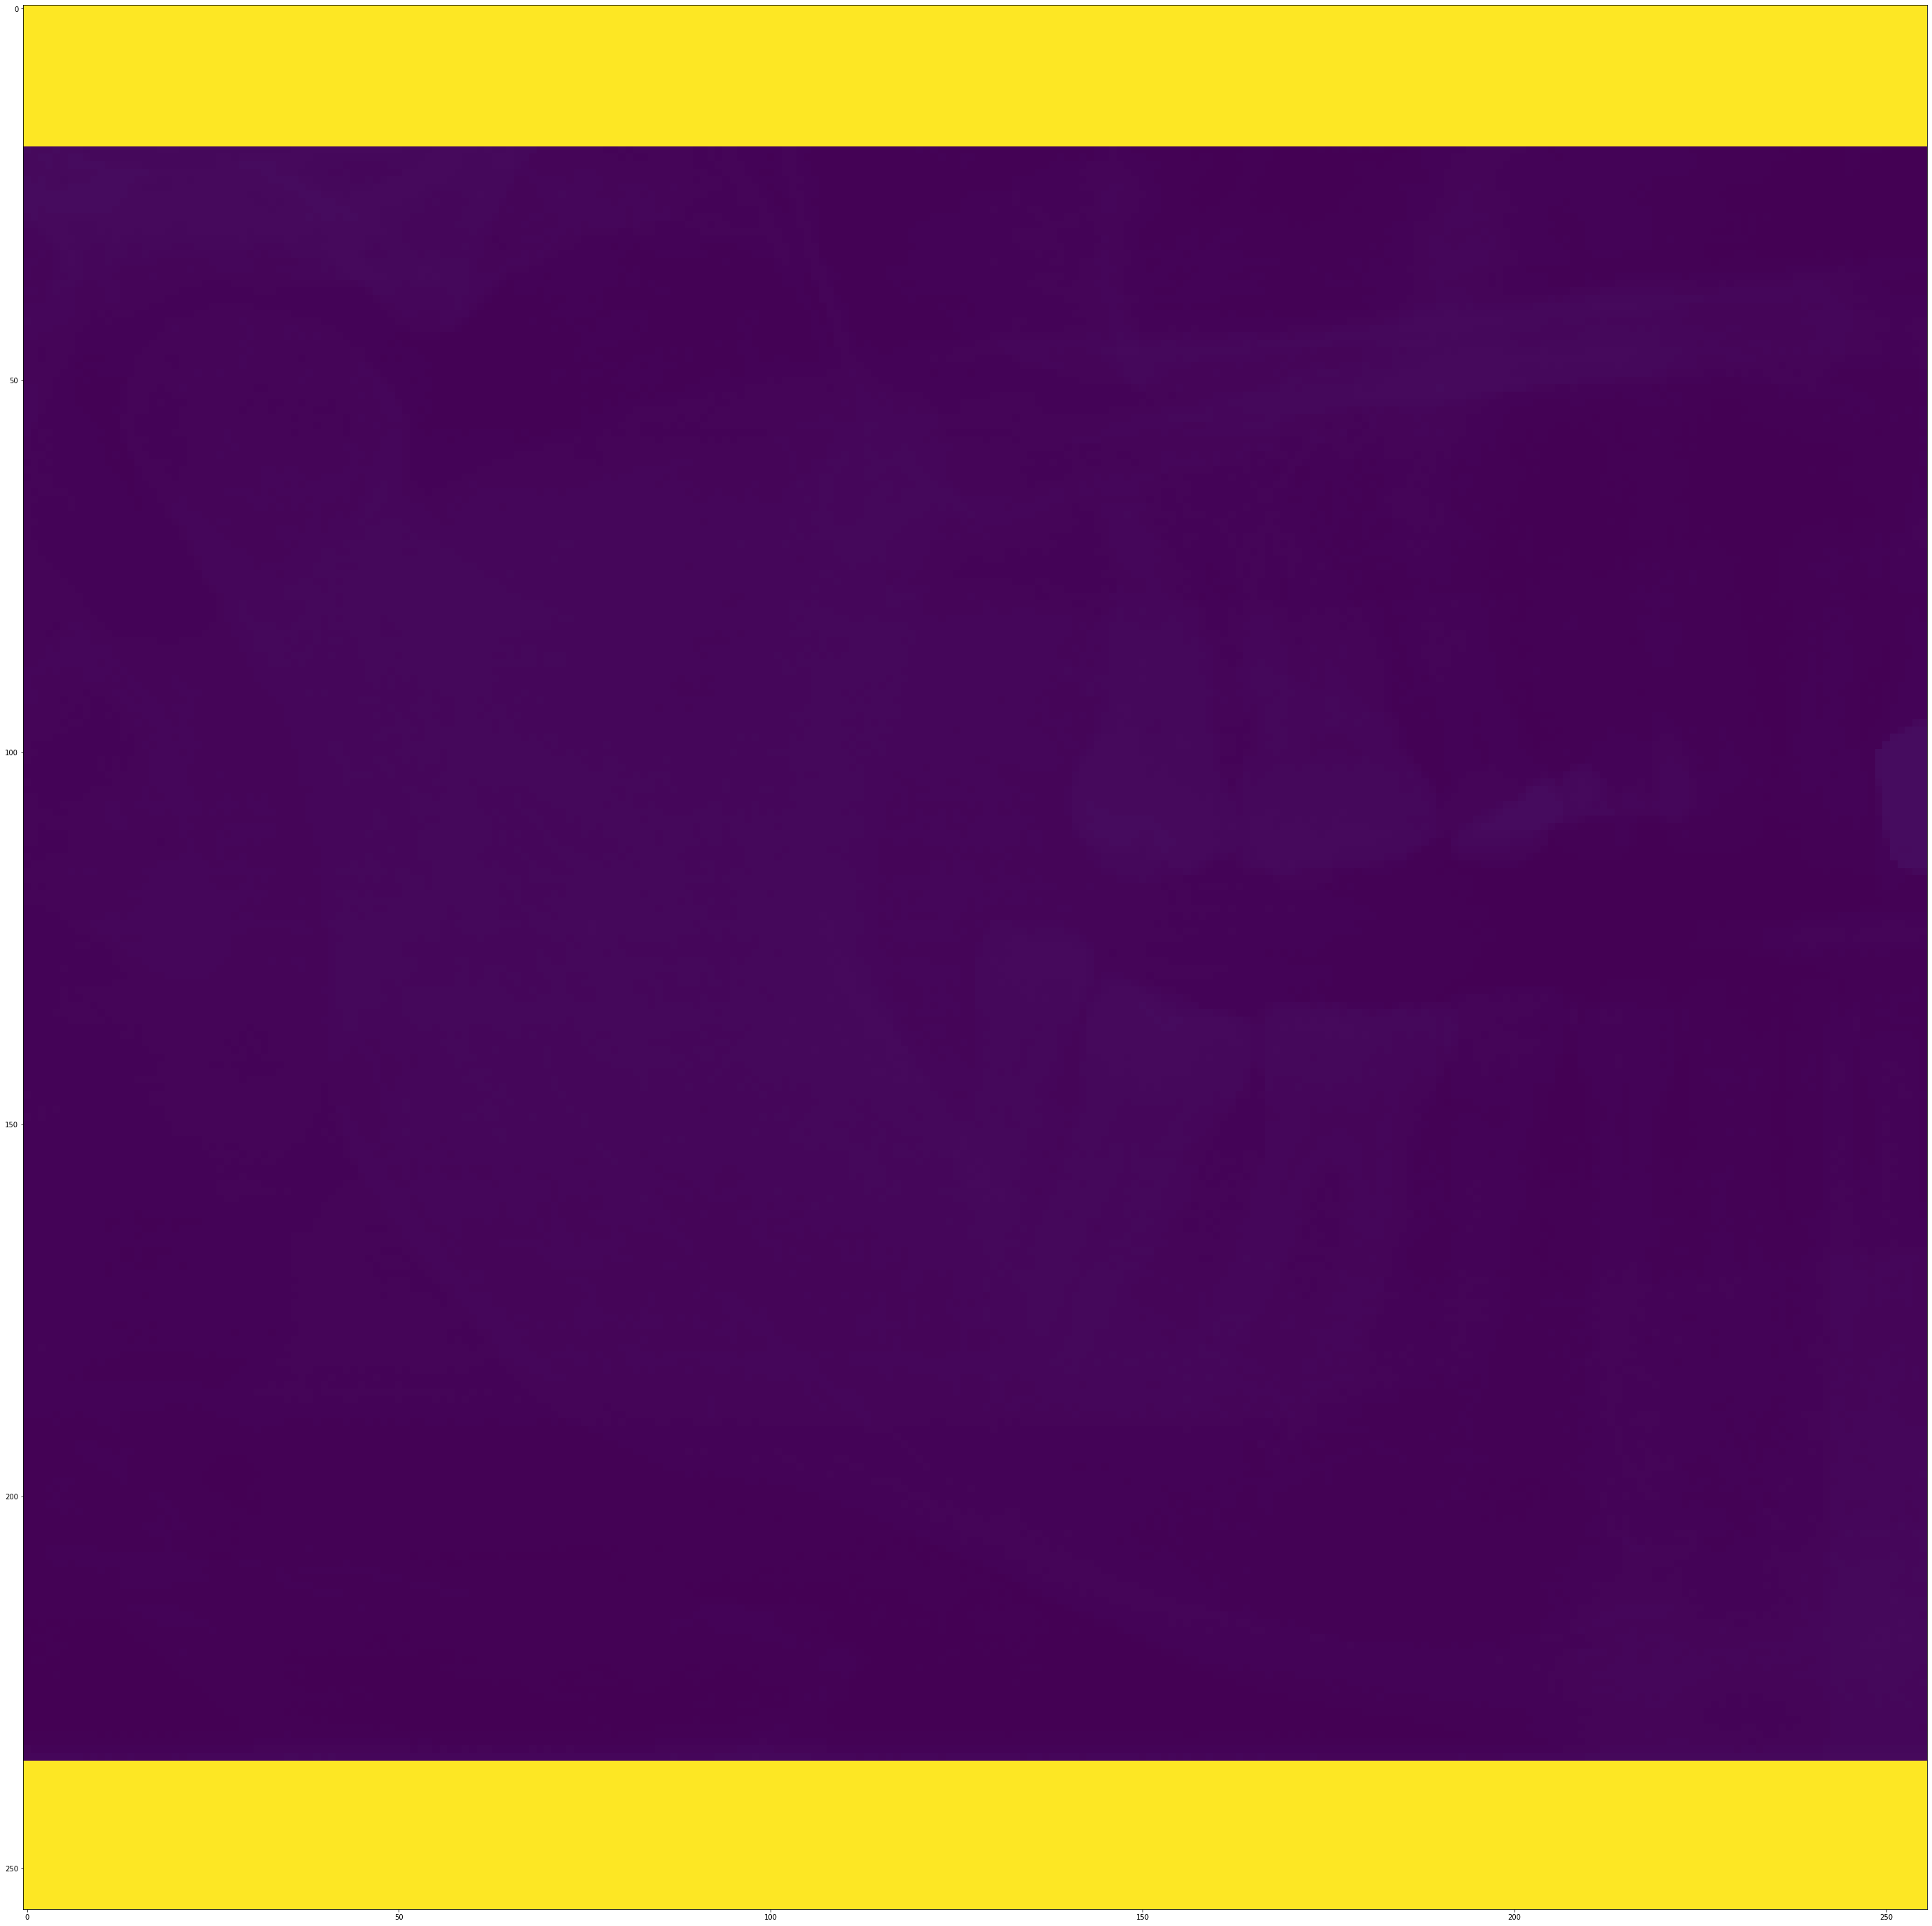

In [103]:
plt.imshow(img0)

In [ ]:
im = sitk.ReadImage(data_dir+label+'.dcm')
im = sitk.GetArrayFromImage(im)[0, :, :]

In [14]:
data_dir = './data/annotated/patches/images_nmasks/'
old_images = []
new_images = []

for label in old_labels:
    im = sitk.ReadImage(data_dir+label+'.dcm')
    im = sitk.GetArrayFromImage(im)[0, :, :]
    old_images.append(im)
    
for label in new_labels:
    im = sitk.ReadImage(data_dir+label+'.dcm')
    im = sitk.GetArrayFromImage(im)[0, :, :]
    new_images.append(im)